# Doc 4 Drive Cycles

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

## 1 Load cycles

In [ ]:
CLTC = pd.read_csv('data/cycles/raw/CLTC-P.csv')

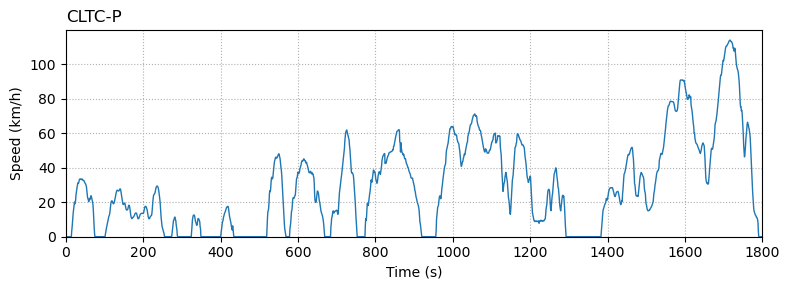

In [219]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(CLTC['Time/(s)'], CLTC['Speed/(km/h)'], linewidth=1)
ax.set_xlim(0,1800)
ax.set_ylim(0,)
ax.grid(linestyle=":")
ax.set_title('CLTC-P', loc='left')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed (km/h)')
plt.tight_layout()
plt.show()

In [ ]:
# fig, ax = plt.subplots(3,1,figsize=(7,4))
# for i, cycle in enumerate([CLTC, NEDC, WLTC]):
#     ax[i].plot(cycle['Time/(s)'], cycle['Speed/(km/h)'], linewidth=1)
#     ax[i].set_xlim(0,)
#     ax[i].set_ylim(0,)
#     ax[i].grid(linestyle=":")
# ax[0].set_title('CLTC-P', loc='left')
# ax[1].set_title('NEDC', loc='left')
# ax[1].set_title('WLTC', loc='left')
# ax[1].set_xlabel('Time (s)')
# ax[1].set_ylabel('Speed (km/h)')
# plt.tight_layout()
# plt.show()

## 2 OpMode aggregation

In [3]:
from calculator import ERCalculator
cal = ERCalculator()

In [4]:
# calculate opmode information
# brake decel bin (-4.5, 0.1, 0.1)
cycle_CLTC, OpModesInfo_CLTC, _ = cal.calCycleBWP(CLTC, CLTC.columns[0], CLTC.columns[1])
# cycle_NEDC, OpModesInfo_NEDC, _ = cal.calCycleBWP(NEDC, NEDC.columns[0], NEDC.columns[1])
cycle_WLTC, OpModesInfo_WLTC, _ = cal.calCycleBWP(WLTC, WLTC.columns[0], WLTC.columns[1])

In [5]:
# # save
with open('data/cycles/opmode/CLTC_opmode.pkl', 'wb') as f:
    pickle.dump(OpModesInfo_CLTC[['trajCount', 'brakeCount', 'brakeFrac', 'brakeDecelBinProp']], f)
# with open('data/cycles/opmode/NEDC_opmode.pkl', 'wb') as f:
    # pickle.dump(OpModesInfo_NEDC[['trajCount', 'brakeCount', 'brakeFrac', 'brakeDecelBinProp']], f)
with open('data/cycles/opmode/WLTC_opmode.pkl', 'wb') as f:
    pickle.dump(OpModesInfo_WLTC[['trajCount', 'brakeCount', 'brakeFrac', 'brakeDecelBinProp']], f)

In [6]:
# chengdu
# brake decel bin (0.1, 4.7, 0.1)
with open('data/cycles/raw/opmode_chengdu.pkl', 'rb') as f:
    opmode_chengdu = pickle.load(f)
opmode_chengdu['brakeFrac'] = opmode_chengdu['brakeCount'] / opmode_chengdu['trajCount']
opmode_chengdu['brakeDecelBinProp'] = opmode_chengdu['brakeDecelBinCount'] / opmode_chengdu['brakeCount']
opmode_chengdu['brakeDecelBinProp'] = opmode_chengdu['brakeDecelBinProp'].apply(lambda x: [i for i in reversed(x)][1:]+[0.0])
opmode_chengdu['brakeDecelBinProp'] = opmode_chengdu['brakeDecelBinProp'].apply(lambda x: [0.0 if i-i else i for i in x])
opmode_chengdu[['trajCount', 'brakeCount', 'brakeFrac', 'brakeDecelBinProp']].to_csv('data/cycles/opmode/Chengdu_opmode.csv')
with open('data/cycles/opmode/Chengdu_opmode.pkl', 'wb') as f:
    pickle.dump(opmode_chengdu[['trajCount', 'brakeCount', 'brakeFrac', 'brakeDecelBinProp']], f)

## 3 Comparison

### Basic cycle information

In [ ]:
# calculate basic cycle information
cycle_info = pd.DataFrame([], columns=['avg speed', 'brake frac', 'avg brake decel'])
cycle_info.loc['CLTC-P'] = [
    cycle_CLTC['Speed/(km/h)'].mean(),
    cycle_CLTC[cycle_CLTC['braking'] == True].shape[0] / cycle_CLTC.shape[0],
    cycle_CLTC[cycle_CLTC['braking'] == True]['acc[m/s2]'].mean()
]

In [8]:
# basic information of chengdu vehicle activities
with open('data/cycles/raw/cycle_info_chengdu.pkl', 'rb') as f:
    cycle_chengdu = pickle.load(f)
cycle_info.loc['Chengdu'] = [
    sum(cycle_chengdu.loc[0, 'speedBinCount'] / cycle_chengdu.loc[0, 'trajCount'] * (np.arange(5,155,5)+np.arange(0,150,5))/2),
    cycle_chengdu.loc[0, 'brakeCount'] / cycle_chengdu.loc[0, 'trajCount'],
    -1 * sum(cycle_chengdu.loc[0, 'brakeDecelBinCount'] / cycle_chengdu.loc[0, 'brakeCount'] * (np.arange(0.1, 4.6, 0.1)+np.arange(0.2,4.7,0.1))/2)
]

In [9]:
cycle_info

,avg speed,brake frac,avg brake decel
CLTC-P,28.959500,0.273333,-0.497967
WLTC,46.524778,0.261667,-0.623378
Chengdu,21.489344,0.344974,-0.935026


### OpMode information

In [2]:
with open('data/cycles/opmode/CLTC_opmode.pkl', 'rb') as f:
    OpModesInfo_CLTC = pickle.load(f)
with open('data/cycles/opmode/Chengdu_opmode.pkl', 'rb') as f:
    OpModesInfo_Chengdu = pickle.load(f)

In [3]:
opmodeID = [ 0,  1, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 27, 28, 29, 30, 33, 35, 37, 38, 39, 40]

In [4]:
import seaborn as sns
def plot_opmode_info(opmode_info, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
    # fig1: bar plot of braking fraction
    ax1.barh(np.arange(opmode_info.shape[0]), opmode_info['brakeFrac'], color='C0',  height=0.5)
    ax1.set_xlabel('Braking fraction')
    ax1.set_ylabel('Operating mode ID')
    ax1.set_yticks(np.arange(opmode_info.shape[0]), opmode_info.index)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-0.5, 22.5)
    ax1.grid(linestyle=':')
    ax1.set_title(title, loc='left')

    # fig2: heatmap of braking deceleration bin proportion
    array = np.stack(opmode_info['brakeDecelBinProp'].values)
    im = ax2.pcolor(array, cmap='Blues', edgecolors='k', linewidths=0.1, vmin=0, vmax=1)
    ax2.set_xlabel('Braking deceleration bin (m/s²)')
    ax2.set_xticks([5, 15, 25, 35, 45], [-4, -3, -2, -1, 0])
    ax2.set_yticks(np.arange(opmode_info.shape[0])+0.5, opmode_info.index)
    ax2.set_xlim(20, 45)
    ax2.set_ylim(0, 23)
    ax2.invert_xaxis()
    # colorbar
    cbar = fig.colorbar(im, ax=ax2, shrink=0.6, pad=0.03)
    cbar.set_label('Proportion')

    # fig3: bar plot of trajectory proportion
    ax3.barh(np.arange(opmode_info.shape[0]), (opmode_info['trajCount']/opmode_info['trajCount'].sum()), color='C0', edgecolor='k',  height=0.5)
    ax3.set_xlabel('OpMode proportion')
    ax3.set_yticks(np.arange(opmode_info.shape[0]), opmode_info.index)
    ax3.set_xlim(0, 0.3)
    ax3.set_ylim(-0.5, 22.5)
    ax3.grid(linestyle=':')

    plt.tight_layout()
    plt.show()

In [36]:
# import seaborn as sns
# def plot_opmode_info(opmode_info, title):
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
#     # fig1: bar plot of braking fraction
#     ax1.barh(np.arange(opmode_info.shape[0]), opmode_info['brakeFrac'], color='C0',  height=0.5)
#     ax1.set_xlabel('Braking fraction')
#     ax1.set_ylabel('Operating mode ID')
#     ax1.set_yticks(np.arange(opmode_info.shape[0]), opmode_info.index)
#     ax1.set_xlim(0, 1)
#     ax1.set_ylim(-0.5, 22.5)
#     ax1.grid(linestyle=':')
#     ax1.set_title(title, loc='left')

#     # fig2: stair plot of braking deceleration bin proportion
#     array = np.stack(opmode_info['brakeDecelBinProp'].values)
#     im = ax2.pcolor(array, cmap='Blues', edgecolors='k', linewidths=0.1, vmin=0, vmax=1)
#     ax2.set_xlabel('Braking deceleration bin (m/s²)')
#     ax2.set_xticks([5, 15, 25, 35, 45], [-4, -3, -2, -1, 0])
#     ax2.set_yticks(np.arange(opmode_info.shape[0])+0.5, opmode_info.index)
#     ax2.set_xlim(20, 45)
#     ax2.set_ylim(0, 23)
#     ax2.invert_xaxis()
#     # colorbar
#     cbar = fig.colorbar(im, ax=ax2, shrink=0.8, pad=0.03)
#     cbar.set_label('Proportion')

#     plt.show()

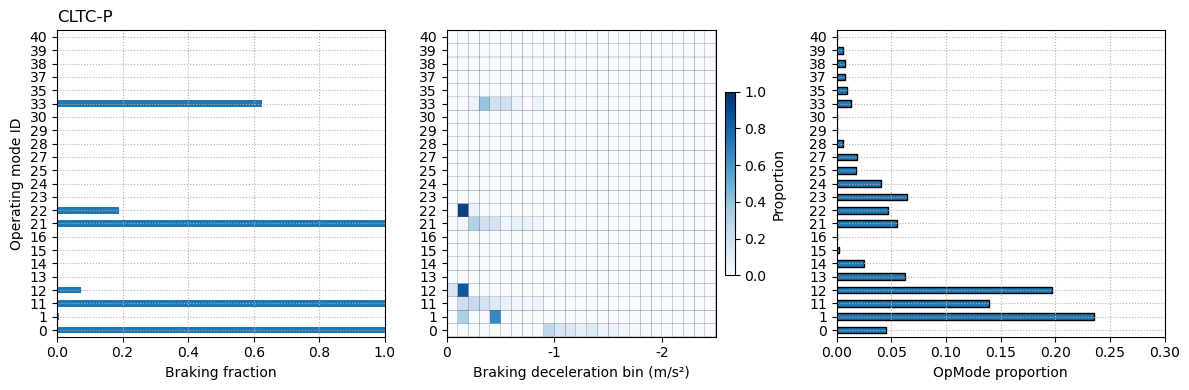

In [5]:
plot_opmode_info(OpModesInfo_CLTC, 'CLTC-P')

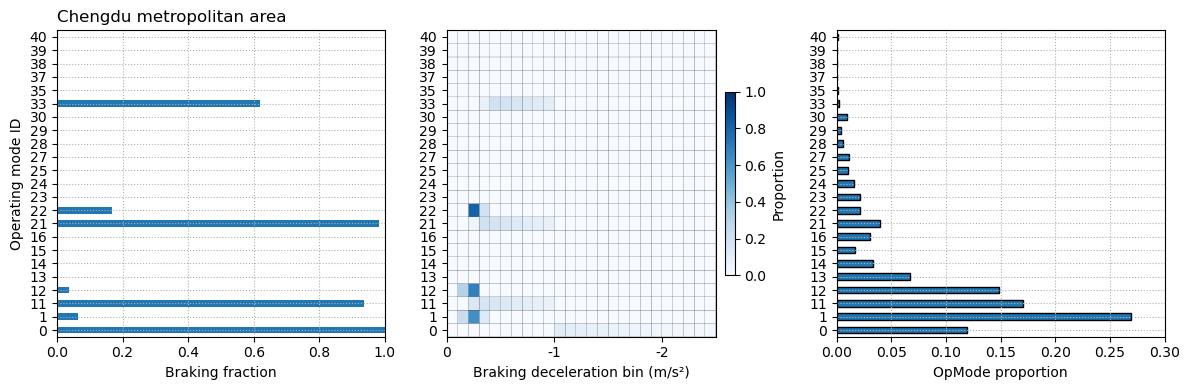

In [6]:
plot_opmode_info(OpModesInfo_Chengdu, 'Chengdu metropolitan area')